In [ ]:
import ollama
from langchain_community.llms import Ollama
import networkx as nx
from langchain.llms import OpenAI
from langchain.chains import RetrievalQA
import pandas as pd
import numpy as np
import re
import string
import nltk
import sklearn
import plotly.express as px
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import OneHotEncoder
import textblob
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize,sent_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
pd.set_option('max_colwidth', 100)
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['OLLAMA_HOST'] = '127.0.0.1:11434'
from langchain_community.embeddings import OllamaEmbeddings
from langchain_community.document_loaders import TextLoader
from langchain_core.documents import Document
from langchain_text_splitters import CharacterTextSplitter
ollama_emb = OllamaEmbeddings(
    model="llama3.1",
)

In [2]:
nltk.download("all")
nltk.download('wordnet')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     C:\Users\derek\AppData\Roaming\nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     C:\Users\derek\AppData\Roaming\nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     C:\Users\derek\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     C:\Users\derek\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     C:\Users\derek\AppData\Roaming\nltk_data...
[

True

In [4]:
import pandas as pd

# Load the dataset
url = "https://raw.githubusercontent.com/bitext/customer-support-llm-chatbot-training-dataset/refs/heads/main/data/Bitext_Sample_Customer_Support_Training_Dataset_27K_responses-v11.csv"
df = pd.read_csv(url, encoding="ISO-8859-1")

# View dataset structure
print("Dataset shape:", df.shape)
print(df.head())


Dataset shape: (26872, 5)
   flags                                                   instruction  \
0      B              question about cancelling order {{Order Number}}   
1    BQZ    i have a question about cancelling oorder {{Order Number}}   
2   BLQZ               i need help cancelling puchase {{Order Number}}   
3     BL                    I need to cancel purchase {{Order Number}}   
4  BCELN  I cannot afford this order, cancel purchase {{Order Number}}   

  category        intent  \
0    ORDER  cancel_order   
1    ORDER  cancel_order   
2    ORDER  cancel_order   
3    ORDER  cancel_order   
4    ORDER  cancel_order   

                                                                                              response  
0  I've understood you have a question regarding canceling order {{Order Number}}, and I'm here to ...  
1  I've been informed that you have a question about canceling order {{Order Number}}. I'm here to ...  
2  I can sense that you're seeking assistance

In [ ]:
# Extract relevant columns
df = df[["instruction", "response"]].dropna()

# Combine question and answer for context
df["content"] = df["instruction"] + " " + df["response"]

# Convert to a list of text
texts = df["content"].tolist()


In [27]:
texts[:5]

["question about cancelling order {{Order Number}} I've understood you have a question regarding canceling order {{Order Number}}, and I'm here to provide you with the information you need. Please go ahead and ask your question, and I'll do my best to assist you.",
 "i have a question about cancelling oorder {{Order Number}} I've been informed that you have a question about canceling order {{Order Number}}. I'm here to assist you! Please go ahead and let me know what specific question you have, and I'll provide you with all the information and guidance you need. Your satisfaction is my top priority.",
 "i need help cancelling puchase {{Order Number}} I can sense that you're seeking assistance with canceling your purchase with the purchase number {{Order Number}}. I apologize for any inconvenience caused, and I'm here to guide you through the process.\n\nTo cancel your purchase, please follow these steps:\n\n1. Log into your account: Visit our {{Online Company Portal Info}} and sign in 

In [35]:
# Find elements containing the phrase "return policy"
filtered_elements = [item for item in texts if "return policy" in item.lower()]

# Print the filtered elements
print(filtered_elements)

['i do not want these article i try to cancel order {{Order Number}} I grasp that you do not want these articles and that you\'ve been trying to cancel order {{Order Number}}. I apologize for any inconvenience this has caused you. Let\'s work together to resolve this issue:\n\n1. Review the Return Policy: I recommend checking our {{Company}}\'s return policy to ensure you qualify for a cancellation or return. You can find this information on our website under the "Returns and Refunds" section.\n\n2. Contact Customer Support: If you are eligible for cancellation or return, please contact our dedicated customer support team. They will guide you through the process, provide any necessary instructions, and assist you in canceling order {{Order Number}}.\n\n3. Provide Order Details: When contacting customer support, make sure to provide them with the order number {{Order Number}}. This will help expedite the cancellation process and ensure accurate assistance.\n\n4. Ask for Assistance: If y

In [ ]:
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS

# Load the embedding model
embedding_model = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

# Create FAISS vector store using from_texts method
vectorstore = FAISS.from_texts(
    texts=texts, 
    embedding=embedding_model
)

# Save the vector store
vectorstore.save_local("customer_support_faiss")

In [ ]:
from langchain.chains import RetrievalQA
from langchain_community.chat_models import ChatOllama
from langchain.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings

# Load the embedding model
embedding_model = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

# Load vectorstore with the embeddings model
vectorstore = FAISS.load_local("customer_support_faiss", embeddings=embedding_model, allow_dangerous_deserialization=True)

# Initialize retriever
retriever = vectorstore.as_retriever()

# Initialize Ollama model
llm = ChatOllama(model="llama3.1:latest", temperature=0)

# Create RAG chain
rag_chain = RetrievalQA.from_chain_type(llm=llm, retriever=retriever)

# Example query
query = "How to cancel an order?"
response = rag_chain.run(query)

print("Response:", response)


Response: Canceling an order can usually be done through your account on our website or by contacting our customer support team. The exact process may vary depending on the platform or service you used to place the order. To cancel an order, follow these general steps:

1. Sign in to Your Account: Access your account on our platform by entering your login credentials.
2. Locate Your Order: Find the order you wish to cancel either in your order history or in the specific section for managing orders.
3. Initiate the Cancellation: Look for the "Cancel" or "Request Cancellation" option associated with the order and click on it.
4. Follow any Prompts or Instructions: Depending on the system, you may need to provide a reason for canceling or confirm your cancellation request.
5. Verify the Cancellation: After completing the cancellation steps, you should receive a confirmation message or email indicating that your order has been canceled.

Keep in mind that cancellation policies may vary dep

### Visualization

In [ ]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, AutoModelForCausalLM
from sklearn.cluster import KMeans
from captum.attr import IntegratedGradients

token = "token"

# Load Model and Tokenizer
model_name = "gpt2"  # Replace with your desired model
tokenizer = AutoTokenizer.from_pretrained(model_name, use_auth_token=token)
model = AutoModelForCausalLM.from_pretrained(model_name, use_auth_token=token, output_attentions=True, output_hidden_states=True)

# Input Data
input_text = "What is your return policy for items I ordered in error?"
inputs = tokenizer(input_text, return_tensors="pt")

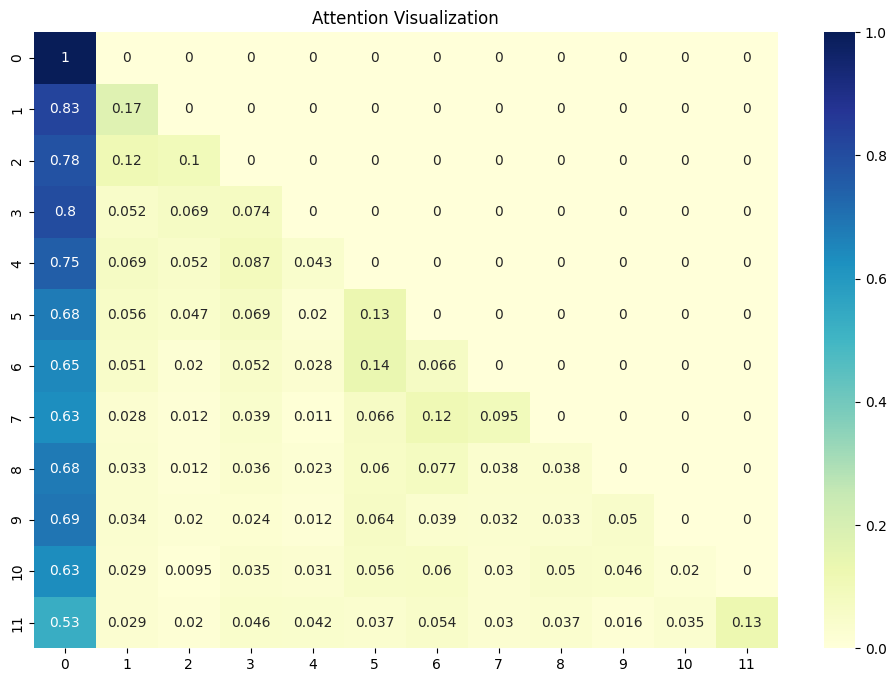

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import matplotlib.pyplot as plt
import seaborn as sns

tokenizer = AutoTokenizer.from_pretrained("gpt2")
model = AutoModelForCausalLM.from_pretrained("gpt2", output_attentions=True)

inputs = tokenizer("What is your return policy for items I ordered in error?", return_tensors="pt")
outputs = model(**inputs)

# Extract attention weights
attention = outputs.attentions[-1].squeeze().detach().cpu().numpy()

# Plot heatmap of attention for the last layer
plt.figure(figsize=(12, 8))  # Adjust the width and height here
sns.heatmap(attention.mean(axis=0), annot=True, cmap="YlGnBu")
plt.title("Attention Visualization")
plt.show()

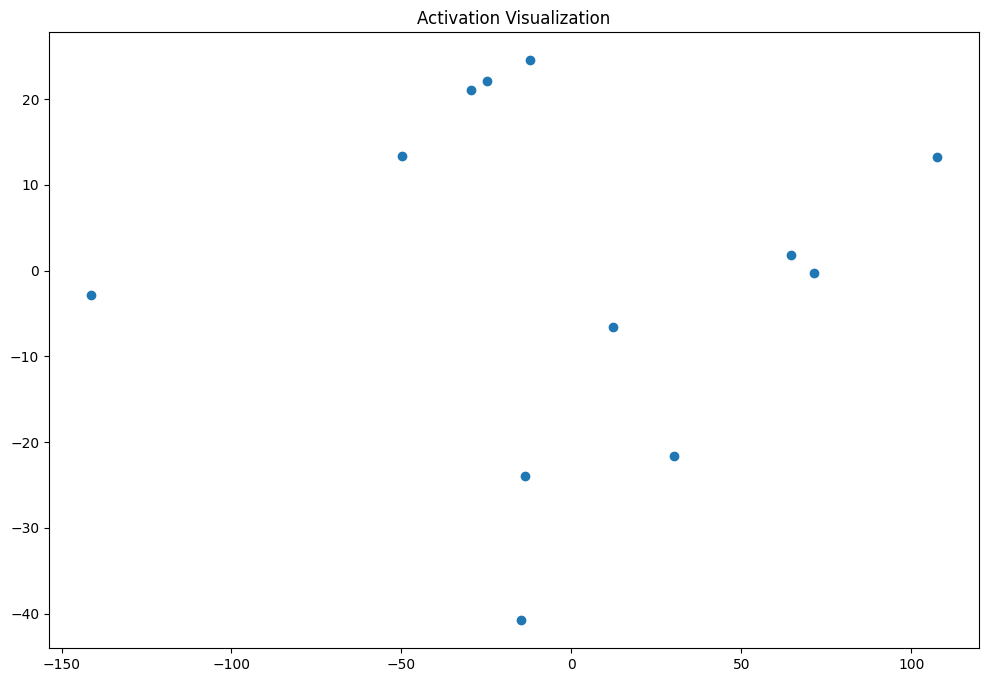

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

tokenizer = AutoTokenizer.from_pretrained("gpt2")
model = AutoModelForCausalLM.from_pretrained("gpt2", output_hidden_states=True)

inputs = tokenizer("What is your return policy for items I ordered in error?", return_tensors="pt")
outputs = model(**inputs)

hidden_states = outputs.hidden_states[-1].detach().cpu().numpy()

# Use PCA to reduce the dimensionality to 2D
pca = PCA(n_components=2)
reduced_states = pca.fit_transform(hidden_states[0])

# Plot the reduced activation
plt.figure(figsize=(12, 8))  # Adjust the width and height here
plt.scatter(reduced_states[:, 0], reduced_states[:, 1], label="Tokens")
plt.title("Activation Visualization")
plt.show()

### Experiments

In [55]:
import numpy as np
from langchain.chains import RetrievalQA, LLMChain
from langchain.prompts import PromptTemplate
from langchain.vectorstores import FAISS
from langchain.chat_models import ChatOllama
from langchain.embeddings import HuggingFaceEmbeddings
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
from bert_score import score
from sklearn.metrics import f1_score
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch

# Load GPT2 model for perplexity calculation (as an example)
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")

# Define query and ground truth
query = "What is your return policy for items I ordered in error?"
#ground_truth = "Our return policy allows customers to return items ordered in error, provided they meet the eligibility criteria outlined in our Returns and Refunds section. Please review the return policy on our website for specific details. If eligible, contact our customer support team with your order number for assistance. Support is available during customer service hours via phone, live chat, or email. Our team will guide you through the process and ensure a smooth resolution."
ground_truth = "There are no returns allowed for items that are ordered in error. Please do not contact customer service further regarding this issue. Thank you."

# Load RAG model
embedding_model = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
vectorstore = FAISS.load_local("customer_support_faiss", embeddings=embedding_model, allow_dangerous_deserialization=True)
retriever = vectorstore.as_retriever()
rag_model = ChatOllama(model="llama2:latest", temperature=0)
#rag_model = ChatOllama(model="llama3.1:latest", temperature=0)
#rag_model = ChatOllama(model="mistral:7b", temperature=0)
#rag_model = ChatOllama(model="gemma2:9b", temperature=0)
#rag_model = ChatOllama(model="phi3:14b", temperature=0)
rag_chain = RetrievalQA.from_chain_type(llm=rag_model, retriever=retriever)

# Define the prompt template
prompt_template = PromptTemplate(
    input_variables=["query"],
    template="Answer the following query: {query}"
)

# Load Non-RAG model
non_rag_model = ChatOllama(model="llama2:latest", temperature=0)
#non_rag_model = ChatOllama(model="llama3.1:latest", temperature=0)
#non_rag_model = ChatOllama(model="mistral:7b", temperature=0)
#non_rag_model = ChatOllama(model="gemma2:9b", temperature=0)
#non_rag_model = ChatOllama(model="phi3:14b", temperature=0)
non_rag_chain = LLMChain(llm=non_rag_model, prompt=prompt_template)

# Test responses
responses = {
    "RAG": rag_chain.run(query),
    "Non-RAG": non_rag_chain.run(query),
}

print("Responses:")
print(responses)

# Perplexity function using Hugging Face GPT-2 (or similar model)
def calculate_perplexity(text):
    # Encode the text
    inputs = tokenizer(text, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs, labels=inputs["input_ids"])
    log_likelihood = outputs.loss * inputs["input_ids"].size(1)
    perplexity = torch.exp(log_likelihood / inputs["input_ids"].size(1))
    return perplexity.item()

# Evaluate responses
def evaluate_responses(predictions, ground_truth):
    metrics = {}
    metrics["BLEU"] = sentence_bleu([ground_truth.split()], predictions.split(), smoothing_function=SmoothingFunction().method1)
    rouge = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True)
    metrics["ROUGE"] = rouge.score(ground_truth, predictions)
    bert_p, bert_r, bert_f1 = score([predictions], [ground_truth], lang="en")
    metrics["BERTScore"] = np.mean(bert_f1.numpy())
    f1 = f1_score([ground_truth == predictions], [True])
    metrics["Perplexity"] = calculate_perplexity(predictions)
    return metrics

results = {model_name: evaluate_responses(response, ground_truth) for model_name, response in responses.items()}

# Print results
for model_name, metrics in results.items():
    print(f"Model: {model_name}")
    for metric, value in metrics.items():
        print(f"  {metric}: {value}")

Responses:
{'RAG': "Thank you for asking! Our return policy allows for the return of items purchased in error within a specified timeframe, typically 30 days. To initiate the return process, please contact our customer support team and provide them with your order number and a brief explanation of why you would like to return the item(s). They will guide you through the next steps and provide you with a Return Merchandise Authorization (RMA) number.\n\nPlease note that the item(s) must be in their original condition, unworn or unused, with all tags and packaging intact. We reserve the right to charge a restocking fee for any returns that do not meet these conditions.\n\nOnce we receive the returned item(s), we will process your refund within 5-7 business days. The original payment method will be credited the refund amount, and you will receive an email notification once the refund has been processed.\n\nIf you have any further questions or concerns about our return policy, please don't

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: RAG
  BLEU: 0.0034319457648426545
  ROUGE: {'rouge1': Score(precision=0.0898876404494382, recall=0.6666666666666666, fmeasure=0.15841584158415842), 'rouge2': Score(precision=0.022598870056497175, recall=0.17391304347826086, fmeasure=0.039999999999999994), 'rougeL': Score(precision=0.056179775280898875, recall=0.4166666666666667, fmeasure=0.09900990099009901)}
  BERTScore: 0.8533732295036316
  Perplexity: 6.718459129333496
Model: Non-RAG
  BLEU: 0.004596288997597152
  ROUGE: {'rouge1': Score(precision=0.09523809523809523, recall=0.5833333333333334, fmeasure=0.16374269005847952), 'rouge2': Score(precision=0.03424657534246575, recall=0.21739130434782608, fmeasure=0.05917159763313609), 'rougeL': Score(precision=0.061224489795918366, recall=0.375, fmeasure=0.10526315789473682)}
  BERTScore: 0.8598507046699524
  Perplexity: 6.61993932723999
